In [1]:
from jitcdde import t
from parameters import *
# from parameters_h_overall import *
from msrDynamics import Node, System
import pandas as pd
from are_model import build_are_model_base_hA

In [2]:
# plotting style 
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "monospace"

# Set a professional color scheme
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
          'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

tls = 22
# Function to update the style of each axis
def update_axis_style(ax, title = '', x_label='', y_label='', x_ticks=True, y_scale='linear'):
    ax.set_title(title,fontsize=tls)
    ax.set_xlabel(x_label,fontsize=tls)
    ax.set_ylabel(y_label,fontsize=tls)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks,labelsize=tls)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True,labelsize=tls)
    ax.set_yscale(y_scale)

lw = 3

In [3]:
# unpack ORNL data 
df_power_reversed = pd.read_csv("./data/insertion.csv",header=None)
df_inlet_reversed = pd.read_csv("./data/fuel_inlet_temp.csv",header=None)
df_outlet_reversed = pd.read_csv("./data/fuel_outlet_temp.csv",header=None)
df_power = df_power_reversed.iloc[::-1] 
df_inlet = df_inlet_reversed.iloc[::-1]
df_outlet = df_outlet_reversed.iloc[::-1]
df_power = df_power.reset_index(drop=True)
df_inlet = df_inlet.reset_index(drop=True)
df_outlet = df_outlet.reset_index(drop=True)
df_inlet[1] = [F_to_K(t) for t in df_inlet[1]]
df_outlet[1] = [F_to_K(t) for t in df_outlet[1]]


# get indices for simulation data
t_before_data = (1110-df_inlet[0][0])*60
duration_data = (df_inlet.iloc[-1][0]-df_inlet[0][0])*60
t_end_data = df_inlet.iloc[-1][0]
t_before_sim = t_ins-t_before_data
T_insert = np.array([t for t in T if (t > (t_before_sim)) and (t < (t_before_sim)+(duration_data))])
i_insert = [t[0] for t in enumerate(T) if (t[1] > (t_before_sim)) and (t[1] < (t_before_sim)+(duration_data))]
adj = (df_inlet[0][0])*60-T_insert[0]
df_outlet = df_outlet[:-2]

# adjust to reported initial values (graphical interpretaion correction)
dp = df_power[1][0]-2.34
df_power[1] = [p-dp for p in df_power[1]]

dt_fin = df_inlet[1][0]-F_to_K(1217)
df_inlet[1] = [tf-dt_fin for tf in df_inlet[1]]

dt_fout = df_outlet[1][0]-F_to_K(1573)
df_outlet[1] = [tf-dt_fout for tf in df_outlet[1]]

# avg temp
ornl_diff = [df_outlet[1][i]-df_inlet[1][i] for i in range(len(df_inlet))]
ornl_avg = sum(ornl_diff)/len(ornl_diff)

In [4]:
params_fb_openmc = [-3.51e-05, -2.98e-05, 6.81e-06] # openmc
# params_fb_estimation = [-6.08617335e-05,  1.4e-05,  2.25540322e-05] # estimation
# params_fb_estimation = [-6.10e-05,  1.4e-05,  3.00e-05] 
params_fb_estimation = [-1.7640e-04, -1.9800e-05,  1.0584e-04]

model_base = build_are_model_base_hA([a_f, a_b, a_c], force_eq = False)
model_base_updated = build_are_model_base_hA([a_f, a_b, a_c], force_eq = True)

model_openmc = build_are_model_base_hA(params_fb_openmc, force_eq = False)
model_openmc_updated = build_are_model_base_hA(params_fb_openmc, force_eq = True)

model_estimation = build_are_model_base_hA(params_fb_estimation, force_eq = False)
model_estimation_updated = build_are_model_base_hA(params_fb_estimation, force_eq = True)

In [5]:
# solve system 
sol_base = model_base.solve(T, populate_nodes = True, max_delay = tau_l, md_step = 0.0001)
sol_base_updated = model_base_updated.solve(T, populate_nodes = True, max_delay = tau_l, md_step = 0.0001)


sol_openmc = model_openmc.solve(T, populate_nodes = True, max_delay = tau_l, md_step = 0.0001)
sol_openmc_updated = model_openmc_updated.solve(T, populate_nodes = True, max_delay = tau_l, md_step = 0.0001)

sol_estimation = model_estimation.solve(T, populate_nodes = True, max_delay = tau_l, md_step = 0.0001)
sol_estimation_updated = model_estimation_updated.solve(T, populate_nodes = True, max_delay = tau_l, md_step = 0.0001)


finalizing integrator...
integrating...


Integration progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress:   5%|▍         | 4637/100000 [00:07<00:40, 2352.72it/s]/home/luke/anaconda3/envs/onion_dynamics/lib/python3.12/site-packages/jitcdde/_jitcdde.py:1644: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  return super().integrate(target_time)[:self.input_base_n]
Integration progress: 100%|██████████| 100000/100000 [00:08<00:00, 12417.47it/s]


populating nodes objects solution vectors...
finalizing integrator...
integrating...


Integration progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress: 100%|██████████| 100000/100000 [00:08<00:00, 11753.86it/s]


populating nodes objects solution vectors...
finalizing integrator...
integrating...


Integration progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress: 100%|██████████| 100000/100000 [00:08<00:00, 11158.72it/s]


populating nodes objects solution vectors...
finalizing integrator...
integrating...


Integration progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress: 100%|██████████| 100000/100000 [00:09<00:00, 10829.42it/s]


populating nodes objects solution vectors...
finalizing integrator...
integrating...


Integration progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress: 100%|██████████| 100000/100000 [00:08<00:00, 12169.84it/s]


populating nodes objects solution vectors...
finalizing integrator...
integrating...


Integration progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress: 100%|██████████| 100000/100000 [00:08<00:00, 11201.41it/s]


populating nodes objects solution vectors...


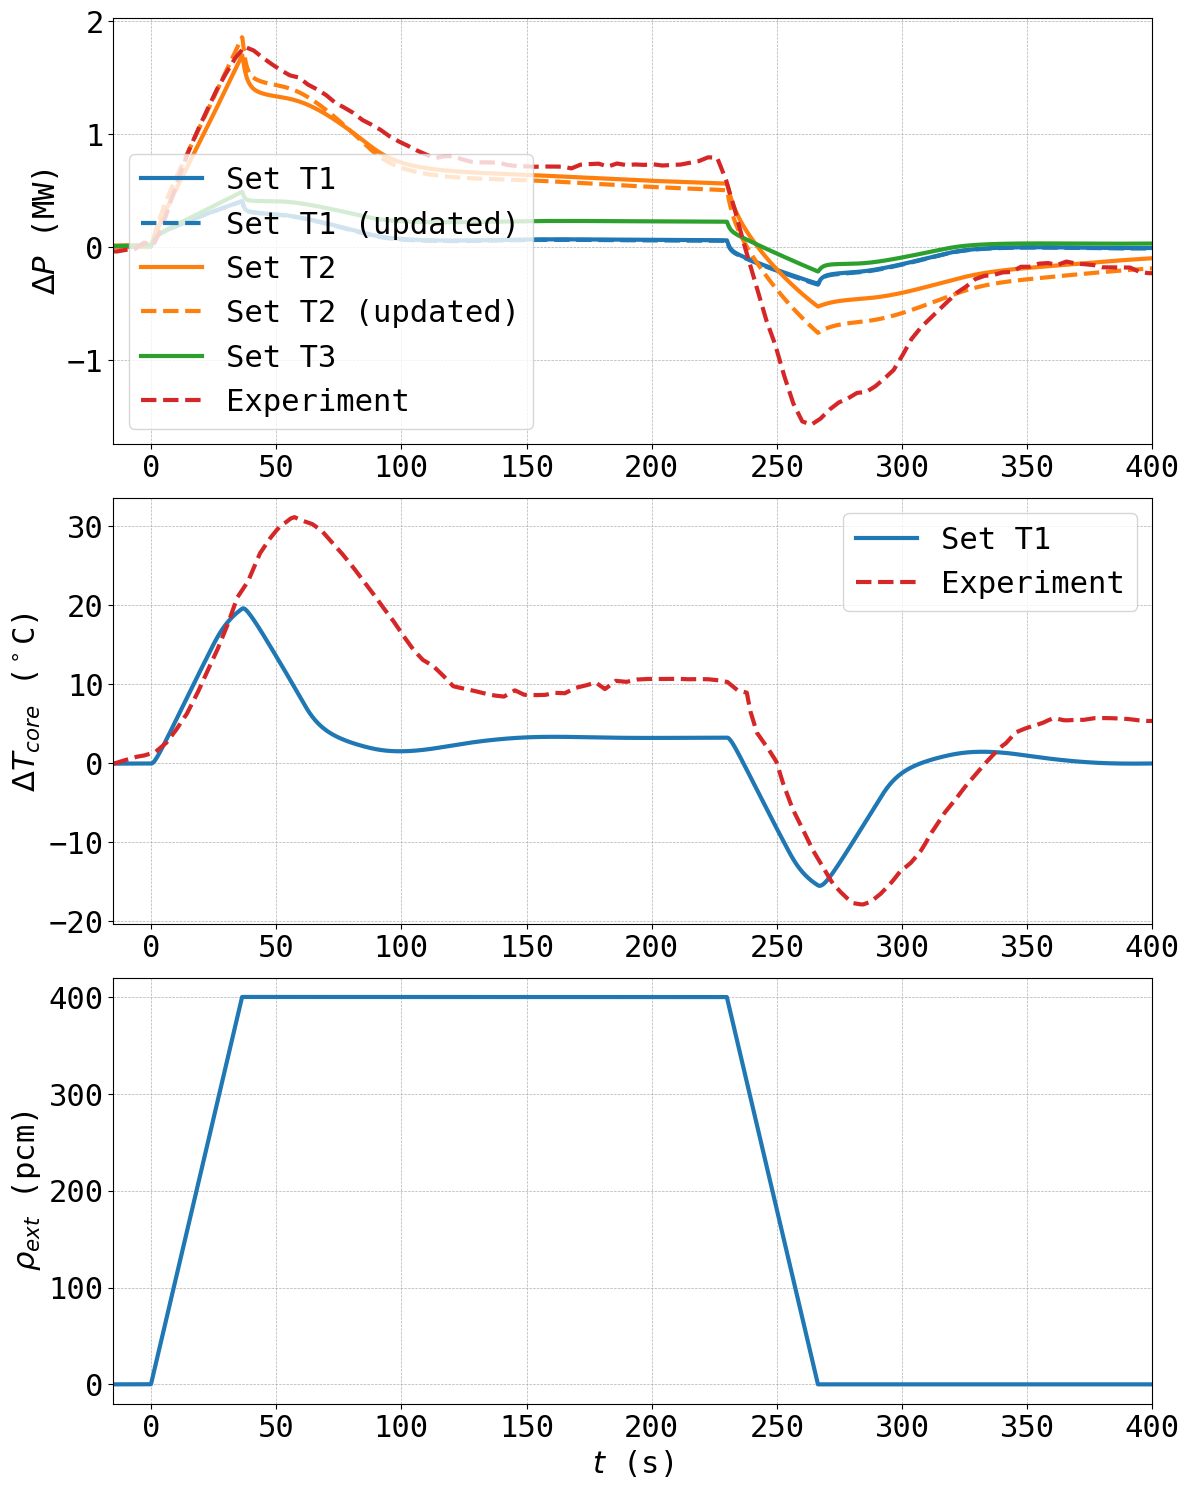

In [6]:
from scipy.interpolate import interp1d

fig, axs = plt.subplots(3,1, figsize = (12,15), sharex = True)

t0, tf = -15.0, 400.0 
def rho_ext(t):
    if t <= t_ins:
        rho = 0.0
    elif t <= t_ins + insert_duration:
        rho = ((t-t_ins))*(11)
    elif t <= t_wd:
        rho = 400
    elif t <= t_wd + insert_duration:
        rho = 400 - (11)*(t-t_wd)
    else:
        rho = 0.0
    return rho*(1e-5) 

rho_dat = np.array([rho_ext(t) for t in T[T>=(300.0+t0)]])


update_axis_style(axs[0], None)
axs[0].plot(T_insert-300,[P*(s-model_base.nodes['n'].y_out[i_insert[0]-1]) for s in model_base.nodes['n'].y_out[i_insert]],label="Set T1",color=colors[0],linewidth=lw)
axs[0].plot(T_insert-300,[P*(s-model_base_updated.nodes['n'].y_out[i_insert[0]-1]) for s in model_base_updated.nodes['n'].y_out[i_insert]],label="Set T1 (updated)",color=colors[0],linewidth=lw, linestyle = '--')
axs[0].plot(T_insert-300,[P*(s-model_openmc.nodes['n'].y_out[i_insert[0]-1]) for s in model_openmc.nodes['n'].y_out[i_insert]],label="Set T2",color=colors[1],linewidth=lw)
axs[0].plot(T_insert-300,[P*(s-model_openmc_updated.nodes['n'].y_out[i_insert[0]-1]) for s in model_openmc_updated.nodes['n'].y_out[i_insert]],label="Set T2 (updated)",color=colors[1],linewidth=lw, linestyle = '--')
axs[0].plot(T_insert-300,[P*(s-model_estimation.nodes['n'].y_out[i_insert[0]-1]) for s in model_estimation.nodes['n'].y_out[i_insert]],label="Set T3",color=colors[2],linewidth=lw)
axs[0].plot(df_power[0]*60-adj-300,df_power[1]-df_power[1][0],label="Experiment",color=colors[3],linestyle='--',linewidth=lw)
axs[0].set_ylabel(r"$\Delta P$ (MW)")
axs[0].set_xlim([t0,tf])
axs[0].legend(fontsize=tls)

df_inlet_interp = interp1d(df_inlet[0]*60-adj,df_inlet[1])
df_outlet_interp = interp1d(df_outlet[0]*60-adj,df_outlet[1])
interp_range = T_insert<710.2269
update_axis_style(axs[1], None)
axs[1].plot(T_insert-300,(model_base.nodes['c_f2'].y_out[i_insert]-model_base.nodes['hx_fh1_f2'].y_out[i_insert])-(model_base.nodes['c_f2'].y_out[i_insert][0]-model_base.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T1",color=colors[0],linewidth=lw)
# axs[1].plot(T_insert-300,(model_openmc.nodes['c_f2'].y_out[i_insert]-model_openmc.nodes['hx_fh1_f2'].y_out[i_insert])-(model_openmc.nodes['c_f2'].y_out[i_insert][0]-model_openmc.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T2",color=colors[1],linewidth=lw)
# axs[1].plot(T_insert-300,(model_estimation.nodes['c_f2'].y_out[i_insert]-model_estimation.nodes['hx_fh1_f2'].y_out[i_insert])-(model_estimation.nodes['c_f2'].y_out[i_insert][0]-model_estimation.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T3",color=colors[2],linewidth=lw)
axs[1].plot(T_insert[interp_range]-300, (df_outlet_interp(T_insert[interp_range]) - df_inlet_interp(T_insert[interp_range])) - (df_outlet_interp(T_insert[interp_range])[0] - df_inlet_interp(T_insert[interp_range][0])), label = "Experiment", color = colors[3], linewidth = lw, linestyle = '--')
axs[1].set_ylabel(r" $\Delta T_{core}$ ($^\circ$C)")
axs[1].set_xlim([t0,tf])
axs[1].legend(fontsize=tls)

update_axis_style(axs[2], None)
axs[2].plot(T[T>=(300.0+t0)]-300, rho_dat*(1e5), label=r'$\rho_{ext}$', linewidth=lw)
axs[2].set_xlim([t0,tf])
axs[2].set_ylabel(r"$\rho_{ext}$ (pcm)")
axs[2].set_xlabel(r"$t$ (s)")

fig.tight_layout()

fig.savefig('are_insert.png')

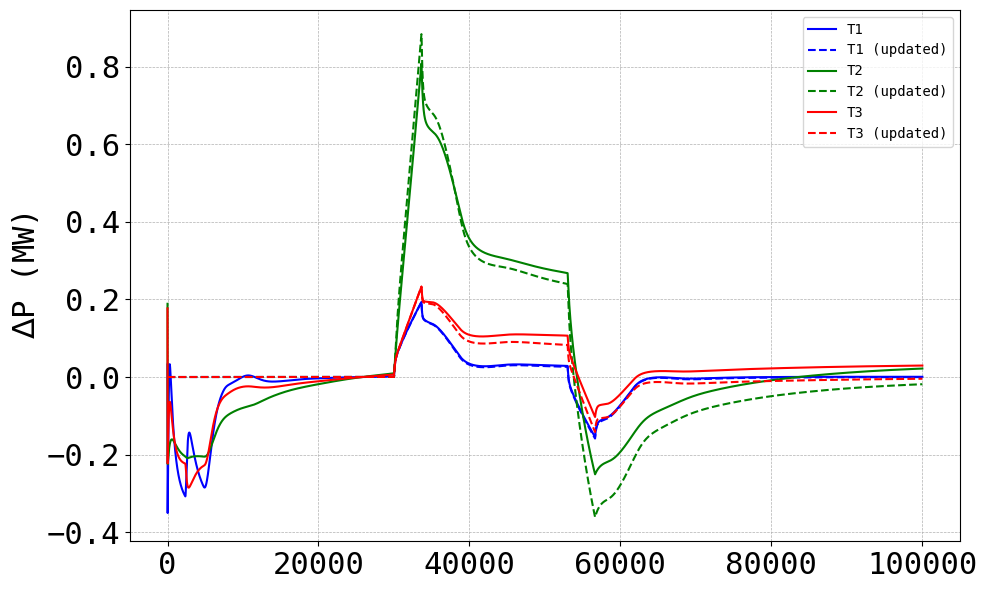

In [7]:
fig, ax = plt.subplots(figsize = (10,6))

update_axis_style(ax)


ax.plot(model_base.nodes['n'].y_out-model_base.nodes['n'].y_out[i_insert[0]], color = "blue", label = 'T1')
ax.plot(model_base_updated.nodes['n'].y_out-model_base_updated.nodes['n'].y_out[i_insert[0]], color = "blue", label = 'T1 (updated)', linestyle = '--')


ax.plot(model_openmc.nodes['n'].y_out-model_openmc.nodes['n'].y_out[i_insert[0]], color = "green", label = 'T2')
ax.plot(model_openmc_updated.nodes['n'].y_out-model_openmc_updated.nodes['n'].y_out[i_insert[0]], color = "green", label = 'T2 (updated)', linestyle = '--')

ax.plot(model_estimation.nodes['n'].y_out-model_estimation.nodes['n'].y_out[i_insert[0]], color = "red", label = 'T3')
ax.plot(model_estimation_updated.nodes['n'].y_out-model_estimation_updated.nodes['n'].y_out[i_insert[0]], color = "red", label = 'T3 (updated)', linestyle = '--')

ax.set_ylabel(r"$\Delta$P (MW)")

ax.legend()

fig.tight_layout()

In [8]:
T[-1]-T[-2]

np.float64(0.009999999999990905)